# Plan




1. Get gradients on transition matrix for n-steps [X]
2. Figure out what to multiply a vector by to obtain skew-symmetric matrix - [x] 
    -1. A~
3. Use caley transform to generate a unitary matrix - [x] 
4. Run whole thing through jax to get PI representation [X]

In [173]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import seaborn
import scipy.optimize as op
from functools import partial
seaborn.set(font_scale=1.5,style='ticks')

# Run with jax

In [174]:
dim = 4
nT = 9
x0 = np.random.normal(size=(dim,1))
A_ = np.random.normal(size=(dim,dim))

A = np.zeros([dim,dim])

for i in range(dim):
    A[i,i:] = A_[i:,i]
    A[i:,i] = -A_[i:,i]
    
A[np.diag_indices_from(A)] = 0
A = (np.eye(dim)-A)@np.linalg.inv(np.eye(dim)+A)

x = np.array([np.linalg.matrix_power(A,i)@x0 for i in range(9)])

In [175]:
#plt.plot(x[:,1])
#plt.yscale('symlog')

In [176]:
Ahat = np.random.normal(size=(dim,dim))


In [177]:
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random


In [178]:
def predict(Ahat,x,y,n,dim):
    Ahat = jnp.reshape(Ahat,(dim,dim))
    return jnp.sum((jnp.dot(jnp.linalg.matrix_power(Ahat,n),x)-y)**2)


predict_funs = [partial(predict,n=i,dim=dim) for i in range(9)]
grad_predict_funs = [grad(i) for i in predict_funs]

In [179]:
def get_basis_tensor(dim):
    """ Returns a tensor that forms a basis for skew symmetric matrices.
        Use np.einsum('i...,i...',params,basis_tensor) to construct this
        matrix
    """
    basis_tensor = []
    for i in range(dim):
        for j in range(i+1,dim):
            bi =  np.zeros([dim,dim])
            bi[i,j] = -1
            bi = bi -bi.T
            basis_tensor.append(bi.T)
    basis_tensor = np.array(basis_tensor)
    return np.asarray(basis_tensor)


In [180]:
basis_tensor = get_basis_tensor(dim)
n_bases = basis_tensor.shape[0]

In [181]:
def caley_transform(skewM,dim):
    """ Perform Caley transform"""
    return (np.eye(dim) - skewM)@np.linalg.inv(np.eye(dim)+skewM)

In [182]:
def predict_all(Ahat,x,predict_funs,grad_predict_funs,dim):
    Ahat = Ahat.reshape(dim,dim)
    #print(Ahat.shape)
    err = 0
    nT = len(x)
    k = 0
    for start_state in range(nT):
        for pred_state in range(start_state+1,nT-start_state):
            n_fwd = pred_state-start_state 
            err += predict_funs[n_fwd](Ahat,x[start_state],x[pred_state])
            k += 1
    return err/k


def predict_all_grad(Ahat,x,predict_funs,grad_predict_funs,dim):
    
    #n_ = len(Ahat.flatten())
    Ahat = Ahat.reshape(dim,dim)
    J = np.zeros(Ahat.shape)
    #print(J.shape)
    nT = len(x)
    k = 0
    for start_state in range(nT):
        for pred_state in range(start_state+1,nT):
            n_fwd =  pred_state-start_state 
            #print(n_fwd,J.shape,)
            #print(start_state,pred_state,n_fwd)
            J = J + grad_predict_funs[n_fwd](Ahat,x[start_state],x[pred_state])
            k+= 1
    #J = J/k
    return J.flatten()
    

In [183]:
predict_funs[1](A,x[0],x[1])

DeviceArray(1.15463195e-14, dtype=float32)

In [184]:
dim*(dim-1)/2

6.0

In [185]:
#%%timeit
op.approx_fprime(Ahat.flatten(),
                 predict_all,
                 1e-4,
                 *(x,predict_funs,grad_predict_funs,dim)
            )

array([ -9.57489014,   5.26428223,  31.33773804,  -4.56809998,
         1.53541565,  -9.75608826, -21.88682556,   8.69750977,
        -4.06265259, -18.96858215,  17.54760742,   5.82695007,
       -15.23017883,  44.81315613,  53.78723145, -23.23150635])

In [186]:
grad_predict_all = grad(predict_all)

In [187]:
#%%timeit
grad_predict_all(Ahat,x,predict_funs,grad_predict_funs,dim)

DeviceArray([[ -9.604504 ,   5.227943 ,  31.296526 ,  -4.5823207],
             [  1.5214062,  -9.774581 , -21.905983 ,   8.695841 ],
             [ -4.1099257, -19.012674 ,  17.4934   ,   5.795663 ],
             [-15.273638 ,  44.813972 ,  53.74293  , -23.23943  ]],            dtype=float32)

In [188]:
predict_all_grad(Ahat,x,predict_funs,grad_predict_funs,dim)

DeviceArray([ -268.52325,  1277.7526 ,  1546.4846 ,  -949.31885,
              -637.0753 , -2033.6174 , -1246.989  ,  1553.0087 ,
              -373.32233, -1513.0414 ,   603.48315,   729.76886,
               633.5216 ,  6603.0757 ,  3287.6145 , -4346.8667 ],            dtype=float32)

In [189]:
params = np.random.normal(size=(1,int(dim*(dim-1)/2)))# + np.eye(dim)
res = op.minimize(predict_all,
           params,
           (x,predict_funs,grad_predict_funs,dim),
           jac=grad_predict_all,
           method='Newton-CG'
           )
print(res.message)

ValueError: cannot reshape array of size 6 into shape (4,4)

In [190]:
res.message

'Desired error not necessarily achieved due to precision loss.'

In [191]:
Ainf = res.x.reshape(dim,dim)

ValueError: cannot reshape array of size 3 into shape (4,4)

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 4 is different from 3)

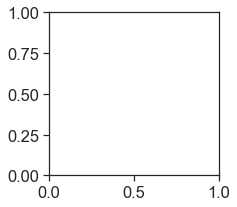

In [192]:
plt.figure(figsize=(14,3))

for i in range(dim):
    
    plt.subplot(1,dim,i+1)
    plt.plot((np.linalg.matrix_power(Ainf,1)@x)[:,i],marker='.')
    plt.plot((np.linalg.matrix_power(A,1)@x)[:,i],marker='.')
    #plt.

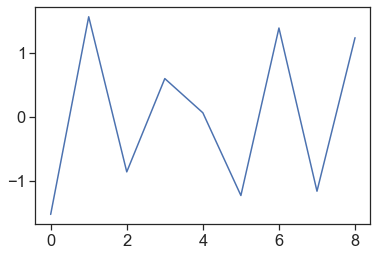

In [193]:
plt.plot((np.linalg.matrix_power(A,5)@x)[:,2])

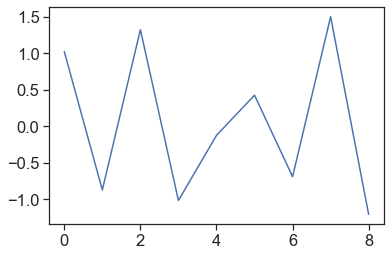

In [194]:
plt.plot(x[:,0])

In [195]:
a = np.random.normal(size=(5,1))
H = np.triu(np.ones([3,3,15]))

# Now do it properly with constraints

In [196]:
def get_basis_tensor(dim):
    """ Returns a tensor that forms a basis for skew symmetric matrices.
        Use np.einsum('i...,i...',params,basis_tensor) to construct this
        matrix
    """
    basis_tensor = []
    for i in range(dim):
        for j in range(i+1,dim):
            bi =  np.zeros([dim,dim])
            bi[i,j] = -1
            bi = bi -bi.T
            basis_tensor.append(bi.T)
    basis_tensor = np.array(basis_tensor)
    return np.asarray(basis_tensor)


In [197]:
def caley_transform(skewM,dim):
    """ Perform Caley transform"""
    return (jnp.eye(dim) - skewM)@jnp.linalg.inv(jnp.eye(dim)+skewM)

In [198]:
params.shape

(1, 6)

In [199]:
def predict(T,x,y,n,dim):
    transition_matrix = jnp.reshape(T,(dim,dim))
    return jnp.sum((jnp.dot(jnp.linalg.matrix_power(transition_matrix,n),x)-y)**2)


#predict_funs = [partial(predict,n=i,dim=dim) for i in range(9)]
#grad_predict_funs = [grad(i) for i in predict_funs]

In [200]:
def predict_all(params,x,dim,basis_tensor):

    err = 0
    nT = len(x)
    k = 0
    skewM = jnp.einsum('i...,i...',params,basis_tensor)
    M = caley_transform(skewM,dim)
    #print(M.shape)
    for start_state in range(nT):
        for pred_state in range(start_state+1,nT-start_state):
            n_fwd = pred_state-start_state 
            err += predict(M,x[start_state],x[pred_state],n_fwd,dim)
            k += 1
    mse = err/k
    print(mse)
    return mse


In [201]:
x.shape

(9, 4, 1)

In [202]:
A

array([[-0.16979037,  0.38627707,  0.42552893,  0.8005538 ],
       [ 0.42921583, -0.49016168, -0.48353302,  0.58456062],
       [ 0.51300481,  0.76466094, -0.38614156, -0.05490362],
       [-0.72372029,  0.16070222, -0.6603148 ,  0.11995038]])

In [203]:
grad_predict_all = grad(predict_all)

In [204]:
a = grad_predict_all(jnp.array(res.x),x,dim,basis_tensor)

ValueError: Size of label 'i' for operand 1 (3) does not match previous terms (6).

In [205]:
a

array([[ 1.19627837],
       [ 1.46028953],
       [-0.80478563],
       [-0.39824127],
       [ 0.12155889]])

In [206]:
def grad_wrapper(params,x,dim,basis_tensor):
    grad = grad_predict_all(jnp.array(params),x,dim,basis_tensor)
    grad = np.array(grad)
    print(grad)
    return grad

## Generate Data

In [207]:
dim = 3
nT = 9

frac = .3

x0 = np.random.normal(size=(dim,1))
A_ = np.random.normal(size=(dim,dim))

A = np.zeros([dim,dim])

for i in range(dim):
    A[i,i:] = A_[i:,i]
    A[i:,i] = -A_[i:,i]
    
A[np.diag_indices_from(A)] = 0
A = (np.eye(dim)-A)@np.linalg.inv(np.eye(dim)+A)

x = np.array([np.linalg.matrix_power(A,i)@x0 for i in range(nT)])

x = frac*x + (1-frac)*np.random.normal(size=x.shape)

basis_tensor = get_basis_tensor(dim)
n_bases = basis_tensor.shape[0]

In [208]:
I = np.eye(dim)
skewORG = (I-A)@np.linalg.inv(I+A)

In [209]:
params = []

n = skewORG.shape[0]
for i in range(n):
    for j in range(i+1,n):
        params.append(skewORG[i,j])
    

In [210]:
params

[0.7695669440181541, -0.2803436152223836, -0.13940672936248777]

In [211]:
predict_all(params,x,dim,basis_tensor)

3.2544544


DeviceArray(3.2544544, dtype=float32)

In [212]:
basis_tensor = get_basis_tensor(dim)
n_bases = basis_tensor.shape[0]

In [213]:
grad_predict_all = grad(predict_all)

In [214]:
#np.einsum('i...,i...',params,basis_tensor)

In [215]:
#out = op.brute(predict_all,
#               [(0,1)]*3,
#               (x,dim,basis_tensor))

In [216]:
n_params = int(dim*(dim-1)/2)
params = np.random.normal(size=(n_params))# + np.eye(dim)
res = op.minimize(predict_all,
           params,
           (x,dim,basis_tensor),
           jac=grad_wrapper,
           method='BFGS'
           )
print(res.message)

4.0853744
Traced<ConcreteArray(4.085374355316162, dtype=float32)>with<JVPTrace(level=2/0)> with
  primal = DeviceArray(4.0853744, dtype=float32)
  tangent = Traced<ShapedArray(float32[])>with<JaxprTrace(level=1/0)> with
    pval = (ShapedArray(float32[]), *)
    recipe = JaxprEqnRecipe(eqn_id=<object object at 0x7f9c415276f0>, invars=(Traced<ConcreteArray(20.0, dtype=float32):JaxprTrace(level=1/0)>, Traced<ShapedArray(float32[]):JaxprTrace(level=1/0)>), outvars=[<weakref at 0x7f9c415de830; to 'JaxprTracer' at 0x7f9c415de650>], primitive=xla_call, params={'device': None, 'backend': None, 'name': 'jvp(true_divide)', 'donated_invars': (False, False), 'inline': True, 'call_jaxpr': { lambda ; a:f32[] b:f32[]. let c:f32[] = div b a in (c,) }}, source_info=<jaxlib.xla_extension.Traceback object at 0x7f9c4156a930>)
[ 1.6256552  -0.36392164 -0.13359547]
4.51035
Traced<ConcreteArray(4.510350227355957, dtype=float32)>with<JVPTrace(level=2/0)> with
  primal = DeviceArray(4.51035, dtype=float32)
  

[ 0.23523068 -0.49886313 -0.4880123 ]
2.6994615
Traced<ConcreteArray(2.6994614601135254, dtype=float32)>with<JVPTrace(level=2/0)> with
  primal = DeviceArray(2.6994615, dtype=float32)
  tangent = Traced<ShapedArray(float32[])>with<JaxprTrace(level=1/0)> with
    pval = (ShapedArray(float32[]), *)
    recipe = JaxprEqnRecipe(eqn_id=<object object at 0x7f9c4151b720>, invars=(Traced<ConcreteArray(20.0, dtype=float32):JaxprTrace(level=1/0)>, Traced<ShapedArray(float32[]):JaxprTrace(level=1/0)>), outvars=[<weakref at 0x7f9c415c8350; to 'JaxprTracer' at 0x7f9c415c8110>], primitive=xla_call, params={'device': None, 'backend': None, 'name': 'jvp(true_divide)', 'donated_invars': (False, False), 'inline': True, 'call_jaxpr': { lambda ; a:f32[] b:f32[]. let c:f32[] = div b a in (c,) }}, source_info=<jaxlib.xla_extension.Traceback object at 0x7f9c415d2f30>)
[ 0.10602057 -0.21883082 -0.24001032]
2.6961958
Traced<ConcreteArray(2.6961960792541504, dtype=float32)>with<JVPTrace(level=2/0)> with
  prima

In [217]:
A

array([[ 0.20624543, -0.95683351,  0.20477417],
       [ 0.86434647,  0.27624449,  0.42023108],
       [-0.45865892,  0.09032509,  0.88400983]])

In [218]:
print(res.message)

Optimization terminated successfully.


In [219]:
out = res.x

In [220]:
skewM = np.einsum('i...,i...',out,basis_tensor)
Ainf = caley_transform(skewM,dim)

In [221]:
assert np.all(skewM==-skewM.T)
print(np.all(skewM==-skewM.T))

True


In [222]:
np.linalg.det(Ainf)

0.9999999

In [223]:
np.allclose(np.linalg.norm(Ainf,axis=0),1)

True

In [224]:
np.min([np.sum(np.abs(np.linalg.matrix_power(Ainf,i)-np.eye(3))) for i in range(1,150)])

0.06078236782923341

In [225]:
np.min([np.sum(np.abs(np.linalg.matrix_power(Ainf,i)-np.eye(3))) for i in range(150)])

0.0

In [226]:
(np.linalg.matrix_power(A,1)@x).shape

(9, 3, 1)

In [227]:
np.sum(((np.linalg.matrix_power(Ainf,1)@x)-(np.linalg.matrix_power(A,1)@x))**2)

19.29856665712296

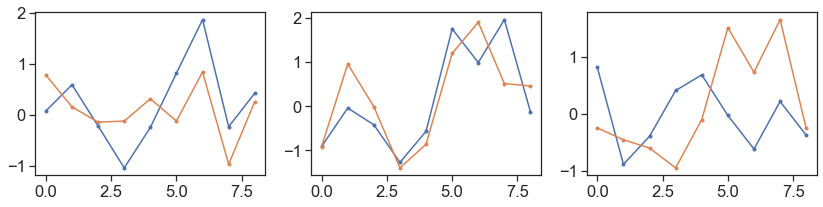

In [228]:
plt.figure(figsize=(14,3))

for i in range(dim):
    
    plt.subplot(1,dim,i+1)
    plt.plot((np.linalg.matrix_power(Ainf,1)@x)[:,i],marker='.')
    plt.plot((np.linalg.matrix_power(A,1)@x)[:,i],marker='.')
    #plt.

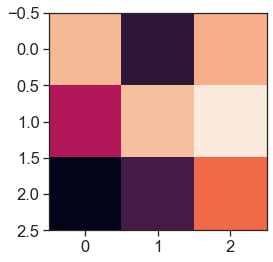

In [229]:
plt.imshow(Ainf)

# Check MCMC fit

# Get this to work with cell activity with structured noise

In [230]:
n_neurons = 120
dim = 3
nT = 9

frac_noise_dynamics = .3

x0 = np.random.normal(size=(dim,1))
A_ = np.random.normal(size=(dim,dim))

A = np.zeros([dim,dim])

for i in range(dim):
    A[i,i:] = A_[i:,i]
    A[i:,i] = -A_[i:,i]
    
A[np.diag_indices_from(A)] = 0
A = (np.eye(dim)-A)@np.linalg.inv(np.eye(dim)+A)

x = np.array([np.linalg.matrix_power(A,i)@x0 for i in range(nT)])

x = frac_noise_dynamics*x #+ (1-frac_noise_dynamics)*np.random.normal(size=x.shape)


W = np.random.normal(size=(n_neurons,dim))
basis_tensor = get_basis_tensor(dim)
n_bases = basis_tensor.shape[0]

In [231]:
def get_spatial_tuning(poke_pos,peak_loc,width):
    """"""
    #for i in range(9):
    distance_matrix = np.abs((poke_pos[peak_loc]-poke_pos)**2).sum(axis=1)
    fr = norm(scale=width).pdf(distance_matrix)
    return fr#distance_matrix
        
def get_task_tuning_line(seq,peak_loc,width):
    task_dists = np.abs(peak_loc-np.arange(9))
#     fr = norm(scale=width).pdf(task_dists)
    fr = np.sin(task_dists)
    return fr[seq]#task_dists[seq]#[task_dists[i] for i in seq]#fr#[fr[i] for i in seq]

In [232]:
act_matrix = []
for nix in range(n_neurons):
    peak_space = np.random.randint(0,9)
    std_space = np.random.randint(1000,12000)
    
    lamda1 = get_spatial_tuning(poke_pos,peak_space,std_space)
    lamda1 = lamda1/np.max(lamda1)
    
    #peak_t1 = np.random.randint(0,9)
    #std_t1 = np.random.randint(3,6)
    #lamda2 = 1*get_task_tuning_line(seq01,peak_t1,std_t1)
    #lamda2 = lamda2/np.max(lamda2)
    #task_tuning = 
    
    
    #peak_t2= np.random.randint(0,9)
    #std_t2 = np.random.randint(1,40)/10.
    w1 = np.random.normal()
    w2 = np.random.normal()
    activity = lamda1 + lamda2 + np.random.normal(scale=.1,size=9)
    act_matrix.append(activity.copy())
act_matrix = np.array(act_matrix).T

NameError: name 'poke_pos' is not defined